# Phase 3: Congruence via Combination Centrality

In this notebook, we calculate the centroid distance measure between vectors of each entity candidate within a single sentence. The vectors will be retrieved from Wikipedia2vec's pre-trained API, which creates vectors for the entire Wikipedia page including its relational links. Comparing two vectors in this way thus lets us make a statement about similar pages and update our prior confidence based on that.

#### Centroid Distance

In Phase 3, we calculate congruence between candidates in pools for mentions in the same sentence. Congruence is defined as the average candidate distance to the centroid vector of the candidate set. This lets us compare entire sets of candidates across all mentions at a time, instead of making pairwise comparisons.

### Import Packages

In [1]:
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from itertools import product

# Progress bar
from tqdm import tqdm

In [2]:
# Base path to input
preds_path = '../../predictions/'

# Load data
# We use a filtered version of our dataframe that includes only sentences with 5 or fewer named entities
# This prevents the combinatorial explosion
full_mentions = pd.read_csv(os.path.join(preds_path, "anchortext_frequency_5x5.csv"), delimiter=",")
full_mentions.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","['European_Union', 'Europe', 'Eu,_Seine-Mariti...","[0.9227799, 0.024651, 0.020196, 0.005346, 0.00..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","['Germany', 'German_language', 'Germans', 'Naz...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","['United_Kingdom', 'British_people', 'Great_Br...","[0.6101256, 0.1146913, 0.0681775, 0.0366451, 0..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"


In [3]:
print("Mentions: ", len(full_mentions), ", Sentences: ", len(full_mentions['sentence_id'].unique()))

Mentions:  13781 , Sentences:  3935


### Parse Saved Candidate Pool

Candidate pools when exported to csv are stored as the string of the list. The below function parses the string back into a list with proper formatted values.

In [4]:
# Demonstrate that list is string
type(full_mentions['candidate_pool_page_ids'][0])

str

In [5]:
# Function to parse list as string
def parse_list_string(list_string, value_type=int):
    
    parsed_list = []
    
    # If candidate pool is empty
    if list_string == "[]" or isinstance(list_string, float):
        pass
    # Else parse
    else:
        # Parses lists of titles as strings
        if value_type==str:
            # Eliminate bracket and parenthesis on either side, split by comma pattern
            parsed_list = re.split("', '|\", \"|', \"|\", \'", list_string[2:-2])

        # Parses lists of IDs as ints
        elif value_type==int:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(int, list_string[1:-1].split(', ')))
        elif value_type==float:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(float, list_string[1:-1].split(', ')))
            
        
    return parsed_list


In [6]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_list_string(full_mentions['candidate_pool_titles'][0], value_type=str)

['European_Union',
 'Europe',
 'Eu,_Seine-Maritime',
 'Europium',
 'Citizenship_of_the_European_Union']

In [7]:
# Manually test function
parse_list_string(full_mentions['candidate_pool_page_ids'][0], value_type=int)

[9317, 9239, 21347120, 9477, 1882861]

In [8]:
# Manually test function
parse_list_string(full_mentions['candidate_pool_page_ids'][13], value_type=int)

[]

In [9]:
# Manually test function
parse_list_string(full_mentions['candidate_pool_priors'][0], value_type=float)

[0.9227799, 0.024651, 0.020196, 0.005346, 0.002079]

In [10]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=str)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])

column = 'candidate_pool_page_ids'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=int)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])


column = 'candidate_pool_item_ids'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=int)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])


column = 'candidate_pool_titles'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=str)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])

column = 'candidate_pool_priors'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=float)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 9643132, 56873217]
After [56783206, 9643132, 56873217]
Before [2073954, 7172840, 26634508]
After [2073954, 7172840, 26634508]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
Before [0.5, 0.3, 0.2]
After [0.5, 0.3, 0.2]
CPU times: user 174 ms, sys: 9.53 ms, total: 184 ms
Wall time: 185 ms


## Retrieve Entity Vectors from Wikipedia2Vec

For provided wikipedia pages, we retrieve a representative entity vector from Wikipedia2vec. This involves passing the normalized title into their get_entity_vector() function. We default to using 100d pre-trained embeddings due to the easier computational requirements, but tested results using higher dimensions as well.

In [11]:
# Package
from wikipedia2vec import Wikipedia2Vec

In [12]:
%%time
# Load unzipped pkl file with word embeddings
w2v = Wikipedia2Vec.load("../../embeddings/enwiki_20180420_100d.pkl")

CPU times: user 96.1 ms, sys: 144 ms, total: 241 ms
Wall time: 335 ms


### Assess Wikipedia2Vec Query Success

We need to measure what percent of candidates in our candidate pools successfully return a vector from Wikipedia2Vec. This should conceivably be 100% given we're passing known Wikipedia pages into this package trained over Wikipedia pages, but there may be some drop-off due to different creation dates or unique names without pages.

In [13]:
# Define text normalization function
def normalize_text(text):
    """
    We define normalized in this notebook as:
    - strip whitespace
    - Spaces, not underlines
    """
    return str(text).strip().replace("_", " ")

In [14]:
# Iterate over candidate pool titles to see what can be returned

found_entity = 0
searched_entity = 0

for i in tqdm(range(len(full_mentions))):
    
    # Retrieve candidate pool
    candidate_pool = full_mentions['candidate_pool_titles'][i]
    
    # Query for each candidate
    for candidate in candidate_pool:
        # Normalize candidate title to form necessary to input into Wikipedia2vec
        candidate = normalize_text(candidate)
        
        # Query Wikipedia2vec get_entity_vector()
        try:
            entity_vector = w2v.get_entity_vector(candidate)
        except KeyError:
            entity_vector = None
        
        # Check if result
        if entity_vector is not None:
            found_entity += 1
        
        # Increment count
        searched_entity += 1

print(f"Wikipedia2vec returned an entity vector for {round(found_entity/searched_entity*100,3)}% of {searched_entity:,} searches")

100%|██████████| 13781/13781 [00:00<00:00, 13947.59it/s]

Wikipedia2vec returned an entity vector for 94.792% of 42,453 searches


## Understand Sentence Properties

First, let's get a sense for what the upper bound of congruent calculations might be per sentence as well as the distribution of counts and average priors.

In [15]:
# What is the maximum number of congruent entities in a single sentence
max(full_mentions['congruent_mentions'].apply(len))

5

5 is expected given we filtered to only sentences containing less than this in Phase 1.

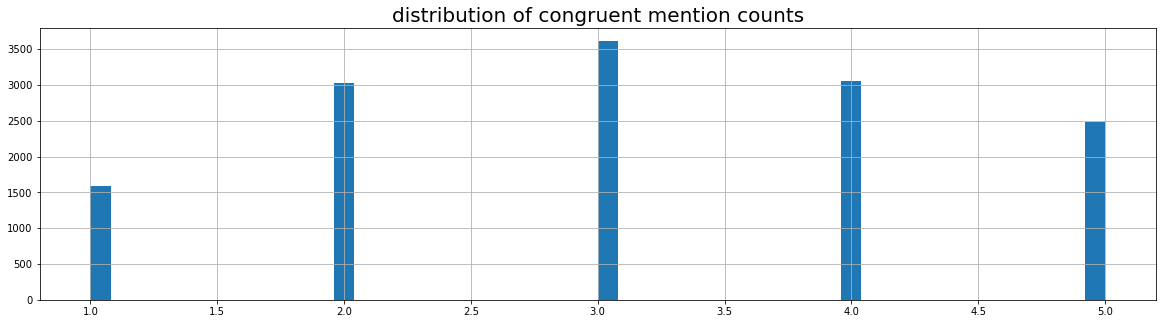

In [16]:
# What is the distribution of congruent mention counts
plt.figure(figsize=(20,5))
full_mentions['congruent_mentions'].apply(len).hist(bins=50)
plt.title("distribution of congruent mention counts", size=20)
plt.show()

We have a near normal distribution around 3 full mentions per sentence. Next, let's get a sense for the average ranking of the right answer.

In [17]:
# Prepare tracking metrics
correct_answer_rank = []
correct_answer_prior = {0:[],1:[],2:[],3:[],4:[]}
correct_answer_not_present = 0
correct_answer_null = 0

# Iterate over whole dataframe
for i in tqdm(range(len(full_mentions))):
    row = full_mentions.iloc[i]
    correct_answer = row['wikipedia_page_ID']
    if isinstance(row['wikipedia_title'], float):
        correct_answer_null += 1
    else:
        try:
            correct_rank = row['candidate_pool_page_ids'].index(correct_answer)
            correct_answer_rank.append(correct_rank)
            correct_answer_prior[correct_rank].append(row['candidate_pool_priors'][correct_rank])
        except ValueError:
            correct_answer_not_present += 1

print(f"Correct answer null {round(correct_answer_null/len(full_mentions)*100,1)}% of the time.")
print(f"Correct answer not present in candidate pool {round(correct_answer_not_present/len(full_mentions)*100,1)}% of the time.")

100%|██████████| 13781/13781 [00:01<00:00, 7436.29it/s]

Correct answer null 29.0% of the time.
Correct answer not present in candidate pool 6.9% of the time.


In [18]:
# Calculate coverage of candidate pools for full mentions with known true values
total_len = len(full_mentions[full_mentions['wikipedia_page_ID'].notnull()])
print(f"We have {round((total_len - correct_answer_not_present) / total_len * 100,3)}% coverage.")

We have 90.271% coverage.


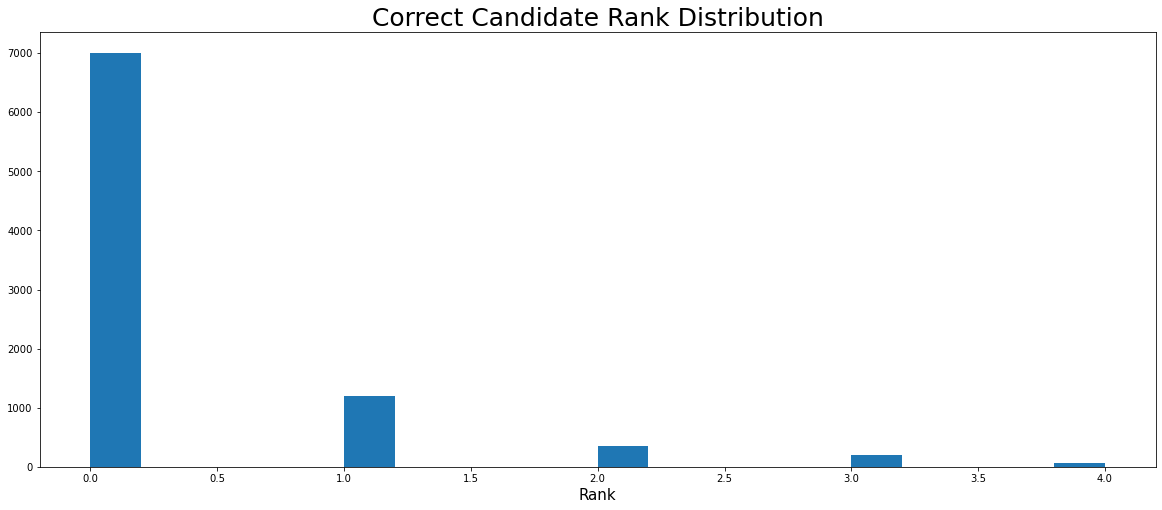

In [19]:
# Plot rank distribution
plt.figure(figsize=(20,8))
plt.hist(correct_answer_rank, bins=20)
plt.title("Correct Candidate Rank Distribution", size=25)
plt.xlabel("Rank", size=15)
plt.show()

In [20]:
# Provide rank quantities
pd.Series(correct_answer_rank).value_counts()

0    7008
1    1193
2     357
3     207
4      68
dtype: int64

In [21]:
# Calculate mean prior confidence for each rank
for k,v in correct_answer_prior.items():
    print(f"Correct Candidate Rank: {k} - Average Prior Confidence: {round(np.mean(v),5)} - Median Prior Confidence: {round(np.median(v),5)}")

Correct Candidate Rank: 0 - Average Prior Confidence: 0.88239 - Median Prior Confidence: 0.95273
Correct Candidate Rank: 1 - Average Prior Confidence: 0.17663 - Median Prior Confidence: 0.15083
Correct Candidate Rank: 2 - Average Prior Confidence: 0.07626 - Median Prior Confidence: 0.07267
Correct Candidate Rank: 3 - Average Prior Confidence: 0.04184 - Median Prior Confidence: 0.04132
Correct Candidate Rank: 4 - Average Prior Confidence: 0.02394 - Median Prior Confidence: 0.01005


When limited to sentences with 5 congruent mentions or less, 79.3% are in First Place and 13.5% are in Second, totaling 92.8% in our top two positions. Our first place candidates have median prior confidence of 0.95, but mean confidence of 0.88, suggesting that for most mentions we are highly confident in its first option, but a few are much lower and more uncertain, bringing the mean down (like a 50/50 estimate). Conversely, in second place, median is 0.15 but mean is 0.176, further suggesting those 50/50 estimates for some mentions bringing the mean up.

Our hope is that congruence will be able to clarify those more evenly split prior values.

## Calculate Congruence Metric between Congruent Entities

We need to iterate through every mention's every candidate to develop the total of all unique combinations in entity vector form. From there, we can iterate through sets to A) create the centroid vector and B) calculate each candidate distance to the centroid. With each candidate distance, we can average into a single distance congruence measure.

We do this through a series of defined functions immediately below. For a more step-by-step logical flow that might aid with understanding, please see the end of this notebook.

### Define Functions to Create Modular Congruent Pipeline

In [22]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        if verbose: print(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100) # Note: this must change if using higher dimensional embeddings
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    # Handle case where candidate pool is empty from prior phase
    # Add 3 arrays of zeros of same dimensionality as embeddings
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [23]:
# Define function to retrieve entity vectors
def create_entity_vector_dict(sentence_mention_ids, single_sentence_df, verbose=False):
    """
    Function iterates over a provided list of congruent mentions,
    finds the associated candidate pool for each mention
    and returns the candidate pool in vector representation
    """
    # Save vectors in dictionary
    vector_dict = {}
    
    # For each full mention we are analyzing in the contextual domain
    for m in sentence_mention_ids:
        
        # Retrieve candidate pool titles
        candidate_pool_titles = single_sentence_df['candidate_pool_titles'][m]
        if verbose: print(candidate_pool_titles)
        
        # Convert candidate pool titles to candidate pool vectors
        candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=verbose)
        
        # Save candidate pool vectors to dictionary
        vector_dict[m] = candidate_pool_vectors
    
    if verbose:
        print(vector_dict.keys())
        for k in vector_dict.keys():
            print(len(vector_dict[k]))

    return vector_dict

In [24]:
# Define function to create every combination of candidates across all mentions in the same sentence
def create_candidate_combos(vector_dict, verbose=False):
    """
    Function takes as input vector_dict, which represents candidate pool vectors for each mention
    Iterates through all candidate vectors to create as product the single list of all combinations of candidates
    Returns that list
    """
    # Prepare list for combination
    candidate_counts = [range(len(v)) for v in vector_dict.values()]
    if verbose: print(candidate_counts)
    
    # Create product combination of all candidates
    unique_combinations = list(product(*candidate_counts))
    
    return unique_combinations

In [25]:
# Define function to calculate centroids
def calculate_centroid_combo_dist(unique_combinations, vector_dict, verbose=False):
    """
    Function takes a list of all possible unique combinations of candidates in vector form,
    - Calculates the centroid of the vectors of that combination,
    - Calculates the distance of each candidate to the centroid
    - Calculates the mean distance for that combination
    Returns a list of mean distance for each candidate combination to its centroid
    """
    
    # Prepare list for each combination's mean distance
    combination_distance = []
    
    # For every unique combination of candidates
    for combo in unique_combinations:
        
        # Translate combination from idx values to vectors
        combo_vector = []
        for i in range(len(combo)):
            combo_vector.append(vector_dict[i][combo[i]]) # Retrieve the vector representation

        # Calculate centroid
        centroid = sum(combo_vector)/len(combo)
                
        # Calculate distance from each candidate to its combination centroid
        candidate_distances = []
        for candidate in combo_vector:
#             candidate_dist = cosine_similarity(candidate.reshape(-1,1), centroid.reshape(-1,1)) # todo use below?
            candidate_dist = pairwise_distances(candidate.reshape(-1,1), centroid.reshape(-1,1), metric='euclidean')
            candidate_distances.append(candidate_dist)
        
        # Saves mean candidate/centroid distance to list
        combination_distance.append(np.mean(candidate_distances))
        
    return combination_distance

In [26]:
# Define function to calculate average prior confidence for a combination
def calculate_combo_prior(unique_combinations, single_sentence_df, verbose=False):
    """
    Function takes as input the list of all possible unique combinations,
    Calculates the average prior confidence for candidates in that combination,
    Returns the list of average prior confidence for every combination
    """
    
    # Prepare list of average combination prior confidence
    combination_avg_prior = []
    
    # For every unique combination of candidates
    for combo in unique_combinations:
        
        # Prepare combination priors
        combination_priors = []
        
        # Retrieve prior confidence using idx
        for i in range(len(combo)):
            mention = single_sentence_df.iloc[i]
            try:
                prior = mention['candidate_pool_priors'][combo[i]]
            except IndexError: # Catches error when candidate pool is empty
                prior = 0 # Set to 0 to bring distance of None vector to centroid to 0
            combination_priors.append(prior)
        
        # Save mean prior
        combination_avg_prior.append(np.mean(combination_priors))

    return combination_avg_prior

### Congruent Predictions Function

This is our main function that takes a sentence ID, calculates congruence for all candidates, updates the prior confidence from prior phase with that congruence and selects predictions iteratively based on that final number.

In [27]:
# Define function to calculate congruent predictions
def get_congruent_predictions(sentence_id, dataframe, with_priors=True, verbose=False):
    """
    Function to calculate congruence metrics over a set of entity full mentions
    and return the predicted candidates based on the congruent metric
    Input:
    - Sentence ID used to filter dataframe
    - Dataframe over which to process
    Output:
    - Prediction for each entity mention
    """
    
    # Filter to dataframe representing single sentence
    # Drop duplicates necessary for sentences with the same mention included twice
    single_sentence_df = dataframe[dataframe['sentence_id'] == sentence_id]\
                        .drop_duplicates(['full_mention', 'wikipedia_URL', 'wikipedia_page_ID', 'wikipedia_title'])\
                        .reset_index(drop=True)
    if verbose: display(single_sentence_df)
    
    # Define numerical representation of congruent mention list
    sentence_congruent_mentions = single_sentence_df['congruent_mentions'][0]
    sentence_mention_ids = np.arange(len(sentence_congruent_mentions))
    if verbose:
        print("Congruent Mentions: ", sentence_congruent_mentions)
        print("Congruent Mentions as numbers: ", sentence_mention_ids)
    
    # Retrieve dictionary of candidate pool vectors for each mention
    vector_dict = create_entity_vector_dict(sentence_mention_ids, single_sentence_df, verbose=verbose)
    if verbose: print("Mentions with Vectors: ", vector_dict.keys())
        
    # Create full list of all unique combinations
    unique_combinations = create_candidate_combos(vector_dict, verbose=verbose)

    # Calculate average candidate distance to that combination's centroid for comparison
    combination_distance = calculate_centroid_combo_dist(unique_combinations, vector_dict, verbose=verbose)
    
    # Add flag for incorporating priors
    if with_priors:
        
        # Calculate average prior confidence for each combination
        combination_avg_prior = calculate_combo_prior(unique_combinations, single_sentence_df, verbose=False)
    
        # Combine congruence distance with prior confidence
        assert len(combination_distance) == len(combination_avg_prior)
        combination_congruence = np.array(combination_distance) * np.array(combination_avg_prior)

    else:
        combination_congruence = combination_distance
        
    # Select combination with smallest distance metric, i.e. most congruent combination
    select_idx = np.argmax(combination_congruence)
    most_congruent_combination = unique_combinations[select_idx]
    if verbose: print("Most Congruent Combination: ", most_congruent_combination)
    
    # Create predictions dictionary
    mention_predictions = {}
    
    # Translate combination list into dictionary
    for i in range(len(most_congruent_combination)):
        mention_predictions[i] = most_congruent_combination[i]
    if verbose: print("Numerical Predictions: ", mention_predictions)
    
    # Use mention predictions to return titles
    readable_predictions = {}
    for k, v in mention_predictions.items():
        if verbose: print(k, v)
        readable_key = sentence_congruent_mentions[k]
        try:
            readable_value = single_sentence_df['candidate_pool_titles'][k][v]
            readable_id = single_sentence_df['candidate_pool_page_ids'][k][v]
        except IndexError: # Handles case where no candidate pool was provided from prior phase
            readable_value = None 
            readable_id = None
        except TypeError:
            # Handles case where no congruence can be calculated
            # Either due to one mention in sentence or two mentions but one with no candidate pool
            readable_value = single_sentence_df['candidate_pool_titles'][0][0] # Just return top value from prior phase
            readable_id = single_sentence_df['candidate_pool_page_ids'][0][0]
        if verbose: print(readable_key, readable_value, readable_id)
        readable_predictions[readable_key] = (readable_value, readable_id)
    
    # Output dictionary with predictions for each entity mention based on congruence
    return readable_predictions

In [28]:
%%time
# Test out function
sentence_id = 0
congruent_predictions = get_congruent_predictions(sentence_id=sentence_id, dataframe=full_mentions, with_priors=True, verbose=True)
print(congruent_predictions)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,EU,NaN,NaN,NaN,0,0,"[EU, German, British]",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","[European_Union, Europe, Eu,_Seine-Maritime, E...","[0.9227799, 0.024651, 0.020196, 0.005346, 0.00..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"[EU, German, British]",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","[Germany, German_language, Germans, Nazi_Germa...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"[EU, German, British]",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","[United_Kingdom, British_people, Great_Britain...","[0.6101256, 0.1146913, 0.0681775, 0.0366451, 0..."


Congruent Mentions:  ['EU', 'German', 'British']
Congruent Mentions as numbers:  [0 1 2]
['European_Union', 'Europe', 'Eu,_Seine-Maritime', 'Europium', 'Citizenship_of_the_European_Union']
European Union
Europe
Eu, Seine-Maritime
Europium
Citizenship of the European Union
Failed Wikipedia2Vec Entity Vector Queries: 0
['Germany', 'German_language', 'Germans', 'Nazi_Germany', 'German_Empire']
Germany
German language
Germans
Nazi Germany
German Empire
Failed Wikipedia2Vec Entity Vector Queries: 0
['United_Kingdom', 'British_people', 'Great_Britain', 'British_Empire', 'Kingdom_of_Great_Britain']
United Kingdom
British people
Great Britain
British Empire
Kingdom of Great Britain
Failed Wikipedia2Vec Entity Vector Queries: 0
dict_keys([0, 1, 2])
5
5
5
Mentions with Vectors:  dict_keys([0, 1, 2])
[range(0, 5), range(0, 5), range(0, 5)]
Most Congruent Combination:  (0, 1, 0)
Numerical Predictions:  {0: 0, 1: 1, 2: 0}
0 0
EU European_Union 9317
1 1
German German_language 11884
2 0
British Unite

In [29]:
# Define testing sentence_id
single_sentence_df = full_mentions[full_mentions['sentence_id'] == sentence_id].reset_index(drop=True)
single_sentence_df

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,EU,NaN,NaN,NaN,0,0,"[EU, German, British]",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","[European_Union, Europe, Eu,_Seine-Maritime, E...","[0.9227799, 0.024651, 0.020196, 0.005346, 0.00..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"[EU, German, British]",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","[Germany, German_language, Germans, Nazi_Germa...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"[EU, German, British]",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","[United_Kingdom, British_people, Great_Britain...","[0.6101256, 0.1146913, 0.0681775, 0.0366451, 0..."


In [30]:
print(single_sentence_df['congruent_mentions'][0])

['EU', 'German', 'British']


In [31]:
accuracy = 0
no_true = 0
for mention, pred in congruent_predictions.items():
    pred_page_id = pred[1]
    try:
        true_page_id = int(single_sentence_df[single_sentence_df['full_mention'] == mention]['wikipedia_page_ID'].values[0])
    except ValueError:
        true_page_id = None
        no_true += 1
    print(mention, "->", true_page_id, "=?", pred_page_id)
    if single_sentence_df[single_sentence_df['full_mention'] == mention]['wikipedia_page_ID'].values[0] == pred_page_id:
        accuracy += 1
print("*************************************************")
print(f"This congruent experiment is {round(accuracy/(len(congruent_predictions)-no_true)*100,3)}% accurate comparing page IDs.")

EU -> None =? 9317
German -> 11867 =? 11884
British -> 31717 =? 31717
*************************************************
This congruent experiment is 50.0% accurate comparing page IDs.


## Calculate Congruence Predictions and Assess Accuracy over Entire Dataframe

We now apply the per-sentence structure over the whole ACY dataframe.

In [32]:
# Max sentence_id in dataframe
max_sentence_id = len(full_mentions['sentence_id'].unique())
print("We have {:,} sentences to predict.".format(max_sentence_id))

We have 3,935 sentences to predict.


In [33]:
# Define function to calculate accuracy
def calculate_accuracy(predictions, dataframe=full_mentions, verbose=False):
    """
    Function to calculate accuracy over generated predictions
    """
    
    # Initialize tracker metrics
    accurate_predictions = 0
    accurate_present = 0
    
    # Iterate through each full mention
    for row in tqdm(range(len(dataframe))):
        mention_df = dataframe.iloc[row]
        
        # Save key values
        sid = mention_df['sentence_id']
        fm = mention_df['full_mention']
        title = mention_df['wikipedia_title']
        page_id = mention_df['wikipedia_page_ID']
        candidate_pool_page_ids = mention_df['candidate_pool_page_ids']
        
        # Retrieve prediction
        pred = predictions[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
        
        # Print comparison (useful for subset review)
        if verbose:
            print(fm, sid, "||| True:", title, page_id, "==? Pred:", norm_pred_title, pred_page_id, "|||",\
            norm_pred_title==title, pred_page_id==page_id, " ||| Present? ", (page_id in candidate_pool_page_ids))
        
        # Compare true vs prediction
        if page_id == pred_page_id:
            accurate_predictions += 1
        if page_id in candidate_pool_page_ids:
            accurate_present += 1
        
    # Print results
    print("------------------------------------------")
    print("Predictive Accuracy: {}%".format(round(accurate_predictions/len(dataframe)*100, 3)))
    print("Answer Present: {}%".format(round(accurate_present/len(dataframe)*100, 3)))
        

### Congruence Accuracy without considering Prior Confidence

We first experiment with calculating congruence accuracy without directly incorporating prior confidence. We still indirectly incorporate it since we took the Top N most confidence (highest ranked) values from the prior phase, but after creating the Top N list, we don't explicitly incorporate it in our calculation for final predictions.

In [34]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_freq_nopr = {}
for sid in tqdm(full_mentions['sentence_id'].unique()):
    congruent_predictions_freq_nopr[sid] = get_congruent_predictions(sid, dataframe=full_mentions,
                                                                     with_priors=False, verbose=False)

100%|██████████| 3935/3935 [10:26<00:00,  6.28it/s] 


In [35]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_nopr, dataframe=full_mentions, verbose=False)

100%|██████████| 13781/13781 [00:02<00:00, 6220.00it/s]

------------------------------------------
Predictive Accuracy: 24.367%
Answer Present: 64.095%


#### Calculate Accuracy only with Full Mentions with Known True

This is a better reflection of our success to avoid potential mistakes handling None values.

In [36]:
# Filter dataframe to only full mentions with known true values
known_true_mentions = full_mentions[full_mentions['wikipedia_page_ID'].notnull()].reset_index()
print("Full Mentions remaining: ", len(known_true_mentions))

Full Mentions remaining:  9785


In [37]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_nopr, dataframe=known_true_mentions, verbose=False)

100%|██████████| 9785/9785 [00:01<00:00, 7225.17it/s]

------------------------------------------
Predictive Accuracy: 34.318%
Answer Present: 90.271%


In [38]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions['sentence_id'])
rand_sentence_df = known_true_mentions[known_true_mentions['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_nopr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 3/3 [00:00<00:00, 1420.35it/s]

Sentence ID: 494, Number of Mentions: 3
------------------------------------------
Nigerian 494 ||| True: Nigeria 21383.0 ==? Pred: British Nigerian 8579573 ||| False False  ||| Present?  True
Liberia 494 ||| True: Liberia 17791.0 ==? Pred: United Nations Mission in Liberia 3045642 ||| False False  ||| Present?  True
ECOMOG 494 ||| True: Economic Community of West African States Monitoring Group 1618193.0 ==? Pred: Economic Community of West African States Monitoring Group 1618193 ||| True True  ||| Present?  True
------------------------------------------
Predictive Accuracy: 33.333%
Answer Present: 100.0%


### Congruence Accuracy considering Prior Confidence

Now, we directly incorporate prior confidence by combining it during the prediction process with our calculated congruent metric. This involves "discounting" congruence by the prior confidence we had in each combination's component candidates.

In [39]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_freq_pr = {}
for sid in tqdm(full_mentions['sentence_id'].unique()):
    congruent_predictions_freq_pr[sid] = get_congruent_predictions(sid, dataframe=full_mentions,
                                                                   with_priors=True, verbose=False)

100%|██████████| 3935/3935 [15:32<00:00,  4.22it/s] 


In [40]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_pr, dataframe=full_mentions, verbose=False)

100%|██████████| 13781/13781 [00:02<00:00, 5031.90it/s]

------------------------------------------
Predictive Accuracy: 50.301%
Answer Present: 64.095%


#### Calculate Accuracy only with Full Mentions with Known True

In [41]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_pr, dataframe=known_true_mentions, verbose=False)

100%|██████████| 9785/9785 [00:01<00:00, 6346.10it/s]

------------------------------------------
Predictive Accuracy: 70.843%
Answer Present: 90.271%


In [42]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions['sentence_id'])
rand_sentence_df = known_true_mentions[known_true_mentions['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_pr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 4/4 [00:00<00:00, 1039.54it/s]

Sentence ID: 1681, Number of Mentions: 4
------------------------------------------
Movement of Socialist Democrats 1681 ||| True: Movement of Socialist Democrats 403110.0 ==? Pred: Movement of Socialist Democrats 403110 ||| True True  ||| Present?  True
Movement of Socialist Democrats 1681 ||| True: Movement of Socialist Democrats 403110.0 ==? Pred: Movement of Socialist Democrats 403110 ||| True True  ||| Present?  True
Movement of Socialist Democrats 1681 ||| True: Movement of Socialist Democrats 403110.0 ==? Pred: Movement of Socialist Democrats 403110 ||| True True  ||| Present?  True
Movement of Socialist Democrats 1681 ||| True: Movement of Socialist Democrats 403110.0 ==? Pred: Movement of Socialist Democrats 403110 ||| True True  ||| Present?  True
------------------------------------------
Predictive Accuracy: 100.0%
Answer Present: 100.0%


## Calculate with *Popularity* Predictions - Known True Only

We also want to see how much of an impact congruence can have on candidate pools produced via page popularity anchor link statistics. These are considered less effective because of large skews that can happen if a word is linked to a very popular page just a single time. Our hypothesis is that congruence may have a larger impact on popularity mentions and to assess this, we compare accuracy with and without prior incorporation for known trues only.

In [43]:
# Load data
full_mentions_pop = pd.read_csv(os.path.join(preds_path, "anchortext_popularity_5x5.csv"), delimiter=",")
full_mentions_pop.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 9891, 9472, 10890716]","[458, 46, 45003, 4916, 185441]","['European_Union', 'Europe', 'Entropy', 'Euro'...","[0.2245141, 0.2015168, 0.0965482, 0.0768826, 0..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 27318, 21148, 21212, 26964606]","[183, 334, 55, 7318, 40]","['Germany', 'Singapore', 'Netherlands', 'Nazi_...","[0.0558084, 0.0548498, 0.044104, 0.0268639, 0...."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[3434750, 31717, 19344654, 26061, 8569916]","[30, 145, 9531, 172771, 1860]","['United_States', 'United_Kingdom', 'BBC', 'Ro...","[0.1243038, 0.0660245, 0.0317426, 0.0291264, 0..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"


In [44]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=str)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])

column = 'candidate_pool_page_ids'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=int)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])


column = 'candidate_pool_item_ids'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=int)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])


column = 'candidate_pool_titles'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=str)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])

column = 'candidate_pool_priors'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=float)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 56873217, 9643132]
After [56783206, 56873217, 9643132]
Before [2073954, 26634508, 7172840]
After [2073954, 26634508, 7172840]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
Before [0.6296296, 0.3703704, 0.0]
After [0.6296296, 0.3703704, 0.0]
CPU times: user 209 ms, sys: 171 ms, total: 380 ms
Wall time: 533 ms


In [45]:
# Prepare tracking metrics
correct_answer_rank = []
correct_answer_prior = {0:[],1:[],2:[],3:[],4:[]}
correct_answer_not_present = 0
correct_answer_null = 0

# Iterate over whole dataframe
for i in tqdm(range(len(full_mentions_pop))):
    row = full_mentions_pop.iloc[i]
    correct_answer = row['wikipedia_page_ID']
    if isinstance(row['wikipedia_title'], float):
        correct_answer_null += 1
    else:
        try:
            correct_rank = row['candidate_pool_page_ids'].index(correct_answer)
            correct_answer_rank.append(correct_rank)
            correct_answer_prior[correct_rank].append(row['candidate_pool_priors'][correct_rank])
        except ValueError:
            correct_answer_not_present += 1

print(f"Correct answer not present in candidate pool {round(correct_answer_not_present/len(full_mentions_pop)*100,1)}% of the time.")
print(f"Correct answer null {round(correct_answer_null/len(full_mentions_pop)*100,1)}% of the time.")

100%|██████████| 13781/13781 [00:01<00:00, 7847.87it/s]

Correct answer not present in candidate pool 10.1% of the time.
Correct answer null 29.0% of the time.


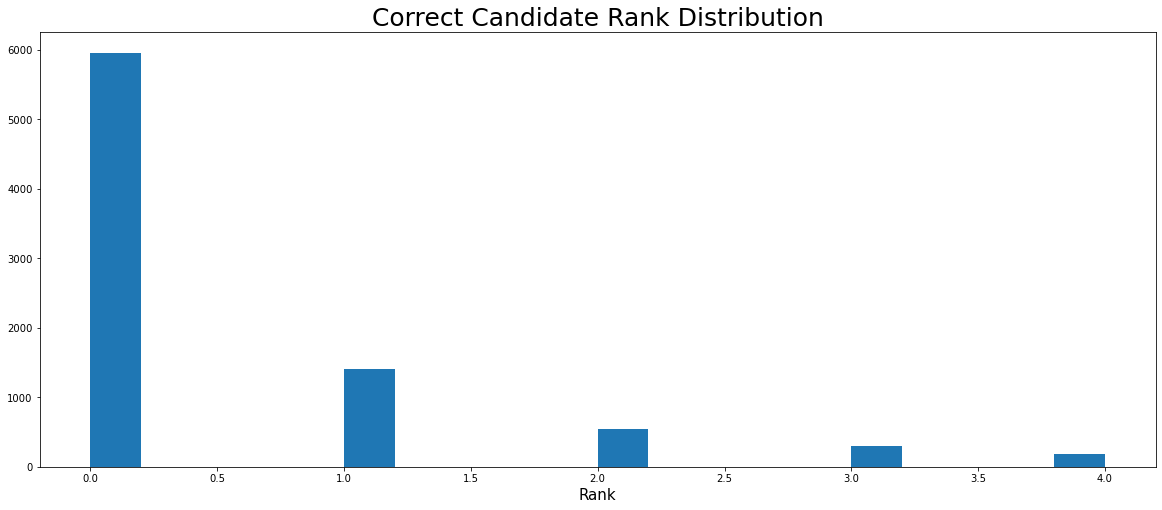

In [46]:
# Plot rank
plt.figure(figsize=(20,8))
plt.hist(correct_answer_rank, bins=20)
plt.title("Correct Candidate Rank Distribution", size=25)
plt.xlabel("Rank", size=15)
plt.show()

In [47]:
# Provide rank numbers
pd.Series(correct_answer_rank).value_counts()

0    5959
1    1405
2     548
3     302
4     185
dtype: int64

In [48]:
# Calculate mean prior confidence for each rank
for k,v in correct_answer_prior.items():
    print(f"Correct Candidate Rank: {k} - Average Prior Confidence: {round(np.mean(v),5)} - Median Prior Confidence: {round(np.median(v),5)}")

Correct Candidate Rank: 0 - Average Prior Confidence: 0.64968 - Median Prior Confidence: 0.73876
Correct Candidate Rank: 1 - Average Prior Confidence: 0.16591 - Median Prior Confidence: 0.14708
Correct Candidate Rank: 2 - Average Prior Confidence: 0.09772 - Median Prior Confidence: 0.08964
Correct Candidate Rank: 3 - Average Prior Confidence: 0.06207 - Median Prior Confidence: 0.05144
Correct Candidate Rank: 4 - Average Prior Confidence: 0.05768 - Median Prior Confidence: 0.04787


##### Congruence Accuracy without considering Prior Confidence

We first experiment with calculating congruence accuracy without directly incorporating prior confidence. We still indirectly incorporate it since we took the Top N most confidence (highest ranked) values in Phase 2, but after creating the Top N list, we don't explicitly incorporate it in our calculation for final predictions.

In [81]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_pop_nopr = {}
for sid in tqdm(full_mentions_pop['sentence_id'].unique()):
    congruent_predictions_pop_nopr[sid] = get_congruent_predictions(sid, dataframe=full_mentions_pop,
                                                                     with_priors=False, verbose=False)

100%|██████████| 3935/3935 [10:24<00:00,  6.30it/s] 


In [82]:
# Filter dataframe to only full mentions with known true values
known_true_mentions_pop = full_mentions_pop[full_mentions_pop['wikipedia_page_ID'].notnull()].reset_index()
print("Full Mentions remaining: ", len(known_true_mentions_pop))

Full Mentions remaining:  9785


In [83]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_nopr, dataframe=known_true_mentions_pop, verbose=False)

100%|██████████| 9785/9785 [00:01<00:00, 6762.79it/s]

------------------------------------------
Predictive Accuracy: 34.246%
Answer Present: 85.835%


In [84]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions_pop['sentence_id'])
rand_sentence_df = known_true_mentions_pop[known_true_mentions_pop['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_nopr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 3/3 [00:00<00:00, 627.45it/s]

Sentence ID: 3136, Number of Mentions: 3
------------------------------------------
Nepal 3136 ||| True: Nepal 171166.0 ==? Pred: April 2015 Nepal earthquake 46514718 ||| False False  ||| Present?  True
Nepali Congress 3136 ||| True: Nepali Congress 364670.0 ==? Pred: Nepali Congress 364670 ||| True True  ||| Present?  True
Nepali Congress 3136 ||| True: Nepali Congress 364670.0 ==? Pred: Nepali Congress 364670 ||| True True  ||| Present?  True
------------------------------------------
Predictive Accuracy: 66.667%
Answer Present: 100.0%


### Congruence Accuracy considering Prior Confidence

Now, we directly incorporate prior confidence by combining it during the prediction process with our calculated congruent metric. This involves "discounting" congruence by the prior confidence we had in each combination's component candidates.

In [85]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_pop_pr = {}
for sid in tqdm(full_mentions_pop['sentence_id'].unique()):
    congruent_predictions_pop_pr[sid] = get_congruent_predictions(sid, dataframe=full_mentions_pop,
                                                                   with_priors=True, verbose=False)

100%|██████████| 3935/3935 [15:46<00:00,  4.16it/s]  


In [86]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_pr, dataframe=known_true_mentions_pop, verbose=False)

100%|██████████| 9785/9785 [00:02<00:00, 4563.43it/s]

------------------------------------------
Predictive Accuracy: 56.004%
Answer Present: 85.835%


In [87]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions_pop['sentence_id'])
rand_sentence_df = known_true_mentions_pop[known_true_mentions_pop['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_pr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 12/12 [00:00<00:00, 1234.80it/s]

Sentence ID: 1839, Number of Mentions: 12
------------------------------------------
Sun Microsystems 1839 ||| True: Sun Microsystems 26980.0 ==? Pred: Sun Microsystems 26980 ||| True True  ||| Present?  True
Sun Microsystems 1839 ||| True: Sun Microsystems 26980.0 ==? Pred: Sun Microsystems 26980 ||| True True  ||| Present?  True
Silicon Valley 1839 ||| True: Silicon Valley 26976.0 ==? Pred: Silicon Valley (TV series) 41577351 ||| False False  ||| Present?  True
Silicon Valley 1839 ||| True: Silicon Valley 26976.0 ==? Pred: Silicon Valley (TV series) 41577351 ||| False False  ||| Present?  True
Kleiner Perkins Caufield & Byers 1839 ||| True: Kleiner Perkins Caufield & Byers 299967.0 ==? Pred: Kleiner Perkins 299967 ||| False True  ||| Present?  True
Kleiner Perkins Caufield & Byers 1839 ||| True: Kleiner Perkins Caufield & Byers 299967.0 ==? Pred: Kleiner Perkins 299967 ||| False True  ||| Present?  True
Kleiner Perkins Caufield & Byers 1839 ||| True: Kleiner Perkins Caufield & Byers 

# Logical Flow Demonstration

The cells below have been included as a more easily understood logical flow to understand how we designed the recursive congruence algorithm for an arbitrary length of full mentions in a sentence. We manually select a sentence and work through that. This is identical to the above but with more printed out breaks.

In [55]:
# Test on manually selected sentence
single_sentence_df = full_mentions[full_mentions['sentence_id'] == 1].drop_duplicates(['full_mention', 'wikipedia_page_ID', 'sentence_id']).reset_index(drop=True)
single_sentence_df

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,Peter Blackburn,NaN,NaN,NaN,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","[Peter_Blackburn_(badminton), Peter_Blackburn_...","[0.5, 0.3, 0.2]"
1,B,BRUSSELS,http://en.wikipedia.org/wiki/Brussels,3708.0,Brussels,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",brussels,"[3708, 575501, 1437181, 269753, 4152470]","[240, 239, 1050331, 28934, 800587]","[Brussels, City_of_Brussels, R.W.D.M._Brussels...","[0.9631528, 0.0115147, 0.0037144, 0.0028973, 0..."
2,B,European Commission,http://en.wikipedia.org/wiki/European_Commission,9974.0,European Commission,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",european commission,"[9974, 24468, 1130631, 1549462, 41222020]","[8880, 8882, 388354, 1780232, 16975389]","[European_Commission, President_of_the_Europea...","[0.9959089, 0.0008894, 0.0005336, 0.0003557, 0..."
3,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","[Germany, German_language, Germans, Nazi_Germa...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
4,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,1,0,"[Peter Blackburn, BRUSSELS, European Commissio...",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","[United_Kingdom, British_people, Great_Britain...","[0.6101256, 0.1146913, 0.0681775, 0.0366451, 0..."


In [56]:
# Congruent Mention
print(single_sentence_df['congruent_mentions'][0])

['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']


In [57]:
# Convert to numerical for easier recursive logic later
sentence_mention_nums = np.arange(len(single_sentence_df['congruent_mentions'][0]))
sentence_mention_nums

array([0, 1, 2, 3, 4])

In [58]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100)
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [59]:
# Save vectors in dictionary
vector_dict = {}

# For each full mention we are analyzing in the contextual domain (i.e. sentence)
for m in sentence_mention_nums:
    
    # Retrieve candidate pool titles
    candidate_pool_titles = single_sentence_df['candidate_pool_titles'][m]
    
    # Convert candidate pool titles to candidate pool vectors
    candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=True)
    
    # Save candidate pool vectors to dictionary
    vector_dict[m] = candidate_pool_vectors
    

Failed Wikipedia2Vec Entity Vector Queries: 2
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 1
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0


In [60]:
# Display vector_dict output
print(vector_dict.keys())
# Preview one candidate vector from a candidate pool vectors
vector_dict[1][1]

dict_keys([0, 1, 2, 3, 4])


memmap([ 5.6705320e-01, -3.3967879e-01,  6.7967427e-01, -8.8146311e-01,
        -9.9295086e-01, -3.8026679e-01,  3.1121460e-01, -1.2859932e-01,
         6.6351652e-01, -1.9566450e+00,  3.7053553e-04, -2.7253684e-01,
         8.7685895e-01, -9.0732628e-01,  3.2349053e-01,  5.2059549e-01,
         5.6463188e-01, -6.1859089e-01,  4.5522106e-01, -7.2353148e-01,
        -9.7908747e-01,  1.5604380e+00, -8.5058933e-01, -3.0102137e-01,
        -7.3634320e-01,  6.0062087e-01, -5.4628011e-02,  6.4058477e-01,
         6.5022165e-01,  2.9072487e-01,  1.2940426e+00, -9.4071068e-02,
         4.9198017e-01,  3.0347526e-01, -5.4809892e-01, -2.0429029e-01,
         9.0489048e-01,  2.7048671e-01,  3.9246964e-01, -1.1840639e+00,
        -4.3033957e-01, -7.5106245e-01, -5.7284772e-01,  1.4852484e+00,
        -8.7626231e-01, -7.4376535e-01, -1.5343527e-01, -7.3458463e-02,
        -3.2605672e-01, -1.0146785e+00,  1.0237430e+00, -9.4328153e-01,
         3.4996659e-02, -2.0044473e-01, -1.9703417e-01,  9.83060

In [61]:
# Structure logic to create all combinations of candidates
candidate_counts = [range(len(v)) for v in vector_dict.values()]
candidate_counts

[range(0, 3), range(0, 5), range(0, 5), range(0, 5), range(0, 5)]

In [62]:
unique_combinations_idx = list(product(*candidate_counts))
unique_combinations_idx[:10]

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 0, 2),
 (0, 0, 0, 0, 3),
 (0, 0, 0, 0, 4),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 0, 1, 2),
 (0, 0, 0, 1, 3),
 (0, 0, 0, 1, 4)]

In [63]:
## Translate unique combination indexes into list of vector combinations
unique_combinations = []
for combo in unique_combinations_idx:
#     print(combo)
    combo_vector = []
    for i in range(len(combo)):
        combo_vector.append(vector_dict[i][combo[i]])
    unique_combinations.append(combo_vector)

In [64]:
# Calculate centroids for each unique combination
centroids = []
for combo in unique_combinations:
    centroids.append(sum(combo)) #/len(combo)) if you want mean

In [65]:
# Each position should now have one
centroids[0]              # Leave as is for sum of vectors
# np.array(centroids[0])/5  # Divide by mention count for mean of vectors

array([ 2.131043  , -0.03438118,  2.4980736 , -0.7308637 , -1.1257738 ,
       -0.49353868,  1.0083045 , -1.0838606 ,  0.75853443, -5.91596   ,
        0.47778386, -1.3803507 ,  2.8838859 , -5.77764   , -1.5809379 ,
       -0.7298596 ,  2.0230465 , -0.5698778 ,  1.3996718 , -0.73016936,
       -1.5379165 ,  2.231394  , -1.0941744 , -1.3733233 , -2.2880337 ,
        1.8583322 ,  2.8878713 , -1.3950173 ,  0.5865395 ,  0.8182961 ,
       -0.37736836, -0.1751889 ,  3.4341693 ,  2.48418   ,  1.6804861 ,
        0.1854988 ,  1.6437321 ,  1.0341145 ,  0.44050485, -1.1708148 ,
        0.7957667 , -1.3546429 ,  0.38562632,  3.6486506 , -0.76347744,
       -1.1840131 , -0.9945575 ,  3.122835  , -2.0672047 , -2.3407288 ,
        2.0564058 ,  1.6348517 ,  1.4340049 , -2.695025  ,  0.19447258,
        0.7308686 ,  2.818136  ,  1.1672243 , -2.6244626 ,  1.1208712 ,
        2.4334676 ,  0.36272705, -1.8655688 ,  1.482802  ,  5.2873936 ,
       -1.9874624 , -2.7909927 ,  1.2789898 , -2.3831098 , -3.96

In [66]:
# Confirm we have a centroid for every set
assert len(unique_combinations) == len(centroids)

In [67]:
# Calculate cosine similarity as distance between each candidate and that set's centroid
set_distances = []
for i in range(len(unique_combinations)):
    candidate_distances = []
    combination = unique_combinations[i]
    centroid = centroids[i]
    for candidate in combination:
        
        # todo which should I be using?
        candidate_distance = cosine_similarity(candidate.reshape(-1, 1), centroid.reshape(-1, 1))
#         candidate_distance = pairwise_distances(candidate.reshape(-1, 1), centroid.reshape(-1, 1), metric='cosine')

        candidate_distances.append(candidate_distance)
    set_distances.append(candidate_distances)

In [68]:
set_distances[0] # Example combination

[array([[-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32),
 array([[ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.]], dtype=float32),
 array([[ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.]], dtype=float32),
 array([[ 1., -1.,  1., ...,  1., -1., -1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 

In [69]:
set_distances[0][0] # Example candidate

array([[-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1., -1.],
       [ 1., -1.,  1., ...,  1., -1., -1.],
       ...,
       [ 1., -1.,  1., ...,  1., -1., -1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32)

In [70]:
average_set_distance = [np.mean(combo) for combo in set_distances]

In [71]:
max(average_set_distance), min(average_set_distance)

(0.0176, -0.00528)

In [72]:
select_idx = np.argmin(average_set_distance)
select_idx

450

In [73]:
most_congruent_predictions = unique_combinations_idx[select_idx]
most_congruent_predictions

(0, 3, 3, 0, 0)

In [74]:
# See what we got done
mention_predictions = {}
for i in range(len(most_congruent_predictions)):
    mention_predictions[i] = most_congruent_predictions[i]
mention_predictions

{0: 0, 1: 3, 2: 3, 3: 0, 4: 0}

In [75]:
single_sentence_df.columns

Index(['mention', 'full_mention', 'wikipedia_URL', 'wikipedia_page_ID',
       'wikipedia_title', 'sentence_id', 'doc_id', 'congruent_mentions',
       'norm_full_mention', 'candidate_pool_page_ids',
       'candidate_pool_item_ids', 'candidate_pool_titles',
       'candidate_pool_priors'],
      dtype='object')

In [76]:
correct_predictions = 0
answer_present = 0

for i in range(len(single_sentence_df)):
    row = single_sentence_df.iloc[i]
    full_mention = row['full_mention']
    wiki_title = row['wikipedia_title']
    wiki_page_id = row['wikipedia_page_ID']
    candidate_pool_titles = row['candidate_pool_titles']
    candidate_pool_page_ids = row['candidate_pool_page_ids']
    pred_idx = mention_predictions[i]
    pred_title = candidate_pool_titles[pred_idx]
    pred_page_id = candidate_pool_page_ids[pred_idx]
    print(f"Text: {full_mention} - True: {wiki_title}, {wiki_page_id} ==? Pred: {pred_title},{pred_page_id}")
    if wiki_page_id == pred_page_id:
        correct_predictions += 1
    if wiki_page_id in candidate_pool_page_ids:
        answer_present += 1

print("*********************************************")
print(f"We predicted {round(correct_predictions/len(single_sentence_df)*100,2)}% mentions correctly.")
print(f"The correct answer was present in {round(answer_present/len(single_sentence_df)*100,2)}% candidate pools.") 

Text: Peter Blackburn - True: nan, nan ==? Pred: Peter_Blackburn_(badminton),56783206
Text: BRUSSELS - True: Brussels, 3708.0 ==? Pred: Brussels_Airport,269753
Text: European Commission - True: European Commission, 9974.0 ==? Pred: European_Commissioner_for_Competition,1549462
Text: German - True: Germany, 11867.0 ==? Pred: Germany,11867
Text: British - True: United Kingdom, 31717.0 ==? Pred: United_Kingdom,31717
*********************************************
We predicted 40.0% mentions correctly.
The correct answer was present in 80.0% candidate pools.


In [77]:
print("You've predicted everything!")

You've predicted everything!
